## Method

In this section, I will use the decision tree and random forest to try predicting the gender of the listener by their linstening events. Also, I will do a regression tree to try predict the tempo of the song by other features. This is because in the last clustering part I found that the tempo is a important feature to classify the song. So I want to see if I can predict the tempo by other features.

Decision Tree:

Decision tree in classification is done by recursively partitioning the data where in each group the variance was minimized. The workflow of a decision tree is quite intuitive, just making decision base on the values of various features, which makes it a white-box method and easy to interpret. The issue with decision tree is it's easy to be influenced by the outliers and get overfitting, so we will find ways to tune the hyperparameters to avoid overfitting.

Random Forest:

Random forest is another way to alleviate the overfitting issue of the decision tree. It is done by training multiple decision trees to form a forest, and the final result will be the average of the results for each tree if it is a regression model, or if the problme is a classification one, the final result will use the majority vote of all the trees in the forest. In this section, we will compare the result of the random forest and the single decision tree with optimal parameters to see which performs better.


## Classification Tree

In [101]:
import pandas as pd

In [102]:
df_event = pd.read_csv('../data/01-modified-data/last.fm.data/listening_events_sample.csv')
df_features = pd.read_csv('../data/01-modified-data/last.fm.data/last_fm_track_info.csv')
df_user = pd.read_csv('../data/01-modified-data/last.fm.data/users_cleaned.csv')

In [104]:
df_compare = pd.merge(df_event, df_features, on='track_id', how='right')
df_compare = pd.merge(df_compare, df_user, on='user_id', how='inner')

In [105]:
df_compare.isnull().sum()

user_id                0
track_id               0
album_id               0
timestamp              0
danceability           0
energy                 0
key                    0
loudness               0
mode                   0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
id                     0
country                0
age                    0
gender                 0
creation_time          0
age_group           2218
dtype: int64

In [106]:
gender_map = {'f': 0, 'm': 1} 
df_compare['gender'] = df_compare['gender'].map(gender_map)

In [107]:
df_compare = df_compare.dropna()

### See the labels distribution

In [108]:
Y = df_compare['gender']

<Axes: xlabel='gender', ylabel='count'>

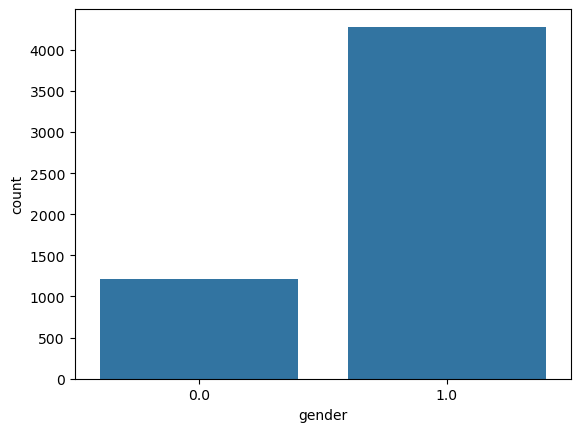

In [182]:
import seaborn as sns

sns.countplot(x='gender', data=df_compare)

In this plot, label 0 represent female and label 1 represnet male. We can see this is a heavily imbalanced dataset, which could potentially cause issues when training a model especially when we are dealing with decision tree. We will try different methods later to try alleviate this issue.

### Implement a baseline model

In [110]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, f1_score
from sklearn.metrics import recall_score, precision_recall_fscore_support

In [111]:
df_compare.columns

Index(['user_id', 'track_id', 'album_id', 'timestamp', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'id', 'country',
       'age', 'gender', 'creation_time', 'age_group'],
      dtype='object')

In [113]:
# Get the predictor features


X = df_compare.drop(['user_id', 'track_id', 'album_id', 'timestamp', 'id', 'country',
        'gender', 'creation_time', 'age_group', 'age'], axis=1)

In [114]:
X.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')

In [115]:
# split the data into training and testing sets
train_size = 0.8
training_mask = df_compare.sample(frac=train_size, random_state=10).index

x_train = X.loc[training_mask]
y_train = Y.loc[training_mask]
x_test = X.drop(training_mask)
y_test = Y.drop(training_mask)

In [116]:
y_train.value_counts()

gender
1.0    3426
0.0     965
Name: count, dtype: int64

In [14]:
from collections import Counter

In [167]:
# initialize a random classifier

def random_classifier(y_data):
    ypred=[]
    for _ in range(0,len(y_data)):
        # ypred.append(int(np.floor((max_label+1)*np.random.uniform(0,1))))
        ypred.append(np.random.choice([0, 1], p=[0.2, 0.8]))

    print("-----RANDOM CLASSIFIER-----")
    print("count of prediction:",Counter(ypred).values()) # counts the elements' frequency
    print("probability of prediction:",np.fromiter(Counter(ypred).values(), dtype=float)/len(y_data)) # counts the elements' frequency
    print("accuracy",accuracy_score(y_data, ypred))
    print("percision, recall, fscore,",precision_recall_fscore_support(y_data, ypred))


In [168]:
random_classifier(y_test)

-----RANDOM CLASSIFIER-----
count of prediction: dict_values([890, 208])
probability of prediction: [0.81056466 0.18943534]
accuracy 0.6657559198542805
percision, recall, fscore, (array([0.20192308, 0.7741573 ]), array([0.17283951, 0.80584795]), array([0.18625277, 0.78968481]), array([243, 855]))


This is a random classifier which randomly assign labels to each data point. Here we adjust the distribution of the random sample to be the basically the same as the dataset. We can see the accuracy is near 70% percent, which is a bit too good for a random classifier. This is because of the imbalance nature of the dataset, and it also shows the accuracy may not be a good metric to evaluate the performance of the decision tree.

### Tune the decision tree

In [118]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
model = model.fit(x_train, y_train)

In [212]:
# COMPLETE THE FOLLOWING CODE TO LOOP OVER POSSIBLE HYPER-PARAMETERS VALUES
test_results=[]
train_results=[]

for num_layer in range(1,30):
    model = tree.DecisionTreeClassifier(max_depth=num_layer)
    model = model.fit(x_train, y_train)

    yp_train=model.predict(x_train)
    yp_test=model.predict(x_test)

    # print(y_pred.shape)
    test_results.append([num_layer,accuracy_score(y_test, yp_test),recall_score(y_test, yp_test,pos_label=0),recall_score(y_test, yp_test,pos_label=1), f1_score(y_test, yp_test,pos_label=0)])
    train_results.append([num_layer,accuracy_score(y_train, yp_train),recall_score(y_train, yp_train,pos_label=0),recall_score(y_train, yp_train,pos_label=1), f1_score(y_train, yp_train,pos_label=0)])


In [213]:
test_results = np.array(test_results)
train_results = np.array(train_results)

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

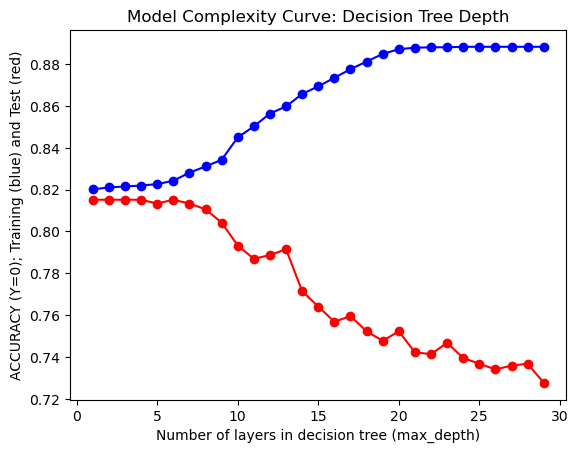

In [214]:
# INSERT CODE TO GENERATE THE THREE PLOTS BELOW (SEE EXPECTED OUTPUT FOR EXAMPLE)

# NOTE: THERE IS A TYPO IN THE THIRD PLOT, IT SHOULD BE RECALL IN THE Y-AXIS LABEL NOT ACCURACY
depth_train = train_results[:, 0]
train_acc = train_results[:, 1]
depth_test = test_results[:, 0]
test_acc = test_results[:, 1]

plt.plot(depth_train, train_acc, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_acc, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('ACCURACY (Y=0); Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

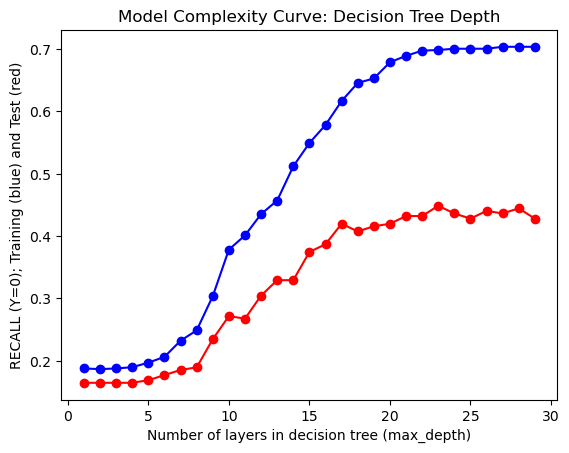

In [215]:
depth_train = train_results[:, 0]
train_recall = train_results[:, 2]
depth_test = test_results[:, 0]
test_recall = test_results[:, 2]

plt.plot(depth_train, train_recall, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_recall, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('RECALL (Y=0); Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

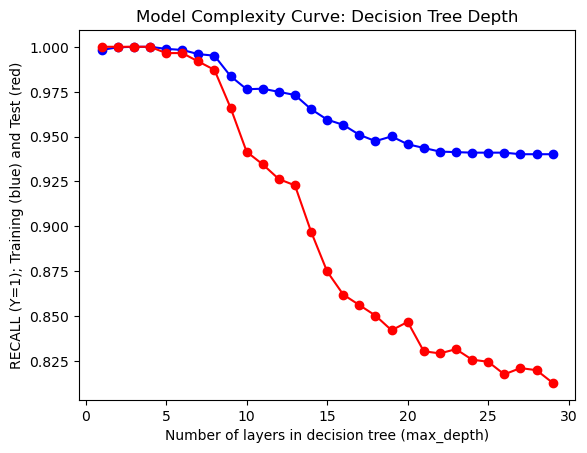

In [216]:
depth_train = train_results[:, 0]
train_recall = train_results[:, 3]
depth_test = test_results[:, 0]
test_recall = test_results[:, 3]

plt.plot(depth_train, train_recall, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_recall, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('RECALL (Y=1); Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

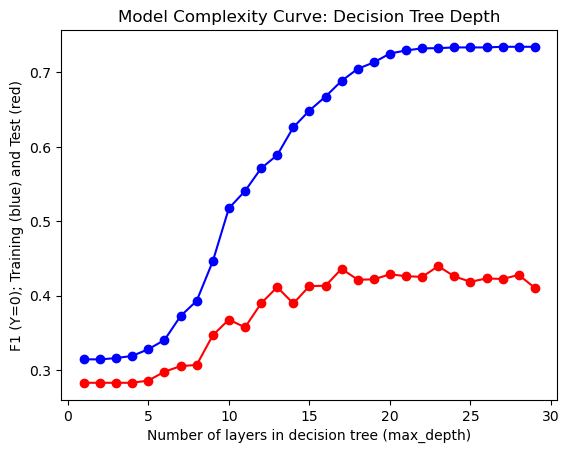

In [218]:
depth_train = train_results[:, 0]
train_recall = train_results[:, 4]
depth_test = test_results[:, 0]
test_recall = test_results[:, 4]

plt.plot(depth_train, train_recall, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_recall, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('F1 (Y=0); Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

Here we can see plots about the accuracy and recall and F1 score of the decision tree with different depth parameter values. Using this we can choose the optimal parameter. However, what we can observe from the plot is that the accuarcy is very good but as we said before it will not be very useful in this case. If we look at the recall and F1 score for the minority class, the performance is bad in general and we can not find a best parameter because none of the parameter could give us a acceptable result. We could make assumption that maybe the imbalance data cause the issue.

### Try to solve the class inbalance using SMOTE oversampling

In [184]:
# Solve the class imbalance problem by using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=20)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

### Redo the tree training with oversampling data

In [187]:
test_results=[]
train_results=[]

for num_layer in range(1,30):
    model = tree.DecisionTreeClassifier(max_depth=num_layer)
    model = model.fit(x_train_smote, y_train_smote)

    yp_train=model.predict(x_train_smote)
    yp_test=model.predict(x_test)

    # print(y_pred.shape)
    test_results.append([num_layer,accuracy_score(y_test, yp_test),recall_score(y_test, yp_test,pos_label=0),recall_score(y_test, yp_test,pos_label=1), f1_score(y_test, yp_test,pos_label=0)])
    train_results.append([num_layer,accuracy_score(y_train_smote, yp_train),recall_score(y_train_smote, yp_train,pos_label=0),recall_score(y_train_smote, yp_train,pos_label=1), f1_score(y_train_smote, yp_train,pos_label=0)])

In [188]:
test_results = np.array(test_results)
train_results = np.array(train_results)

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

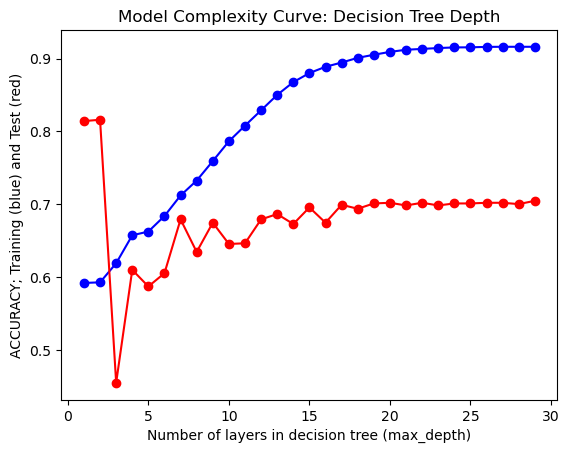

In [193]:
depth_train = train_results[:, 0]
train_acc = train_results[:, 1]
depth_test = test_results[:, 0]
test_acc = test_results[:, 1]

plt.plot(depth_train, train_acc, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_acc, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('ACCURACY; Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

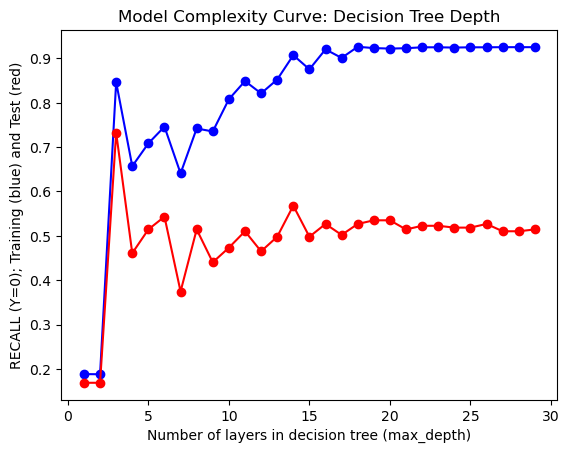

In [190]:
depth_train = train_results[:, 0]
train_recall = train_results[:, 2]
depth_test = test_results[:, 0]
test_recall = test_results[:, 2]

plt.plot(depth_train, train_recall, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_recall, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('RECALL (Y=0); Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

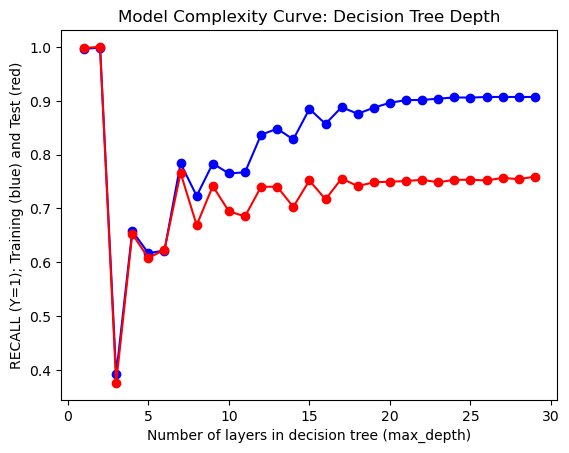

In [191]:
depth_train = train_results[:, 0]
train_recall = train_results[:, 3]
depth_test = test_results[:, 0]
test_recall = test_results[:, 3]

plt.plot(depth_train, train_recall, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_recall, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('RECALL (Y=1); Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

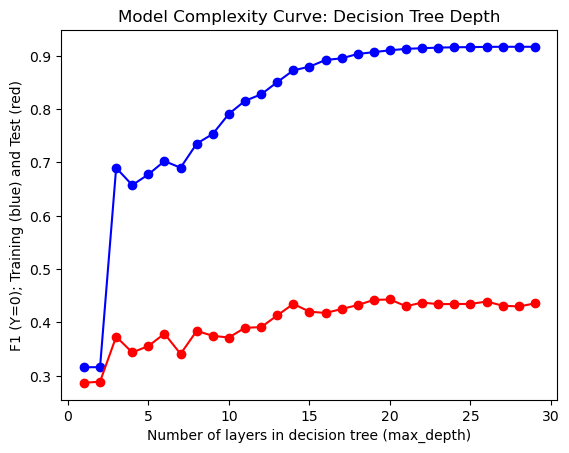

In [192]:
depth_train = train_results[:, 0]
train_recall = train_results[:, 4]
depth_test = test_results[:, 0]
test_recall = test_results[:, 4]

plt.plot(depth_train, train_recall, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_recall, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('F1 (Y=0); Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

In these plot, we can see the difference between the result from the orignal data and the oversample data. When the depth is 3, there is an siginificant drop on the recall of the majority class while on the other hand the recall for the minority class has dramatically increased. This effect was not observed when using the original data to train. Something done in the third level of the tree has caused this effect. To see what is going on, we can plot the tree on both depth. However, we still can't find a optimal parameter because the F1 score for the minority class is at maximum about 0.4, which is not acceptable. We can say that the model did not sufficiently learned from the data. 

### Try downsampling the majority class

In [132]:
from imblearn.under_sampling import RandomUnderSampler

In [133]:
down = RandomUnderSampler(random_state=10)
x_train_down, y_train_down = down.fit_resample(x_train, y_train)

In [200]:
test_results=[]
train_results=[]

for num_layer in range(1,30):
    model = tree.DecisionTreeClassifier(max_depth=num_layer)
    model = model.fit(x_train_down, y_train_down)

    yp_train=model.predict(x_train_down)
    yp_test=model.predict(x_test)

    # print(y_pred.shape)
    test_results.append([num_layer,accuracy_score(y_test, yp_test),recall_score(y_test, yp_test,pos_label=0),recall_score(y_test, yp_test,pos_label=1), f1_score(y_test, yp_test,pos_label=0)])
    train_results.append([num_layer,accuracy_score(y_train_down, yp_train),recall_score(y_train_down, yp_train,pos_label=0),recall_score(y_train_down, yp_train,pos_label=1), f1_score(y_train_down, yp_train,pos_label=0)])

In [201]:
test_results = np.array(test_results)
train_results = np.array(train_results)

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

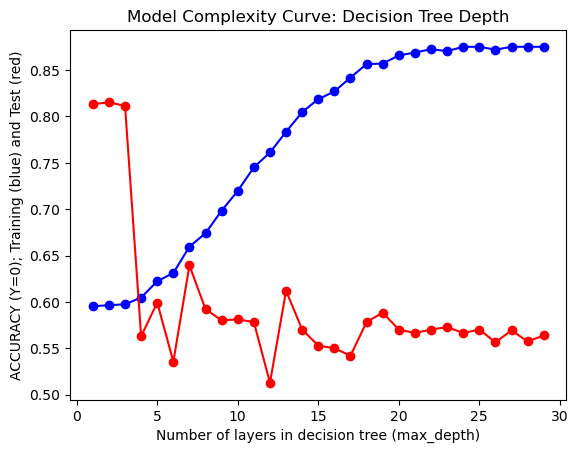

In [202]:
depth_train = train_results[:, 0]
train_acc = train_results[:, 1]
depth_test = test_results[:, 0]
test_acc = test_results[:, 1]

plt.plot(depth_train, train_acc, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_acc, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('ACCURACY (Y=0); Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

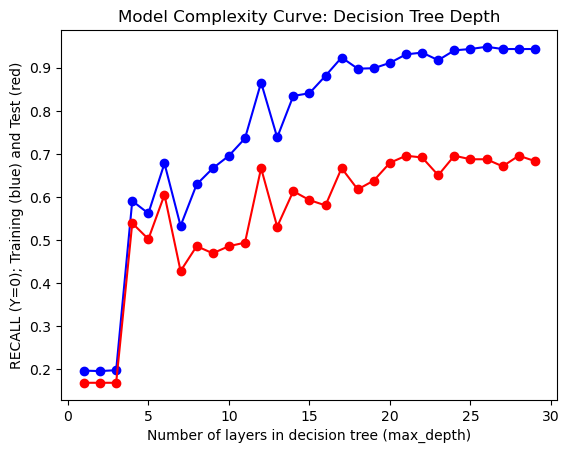

In [203]:
depth_train = train_results[:, 0]
train_recall = train_results[:, 2]
depth_test = test_results[:, 0]
test_recall = test_results[:, 2]

plt.plot(depth_train, train_recall, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_recall, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('RECALL (Y=0); Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

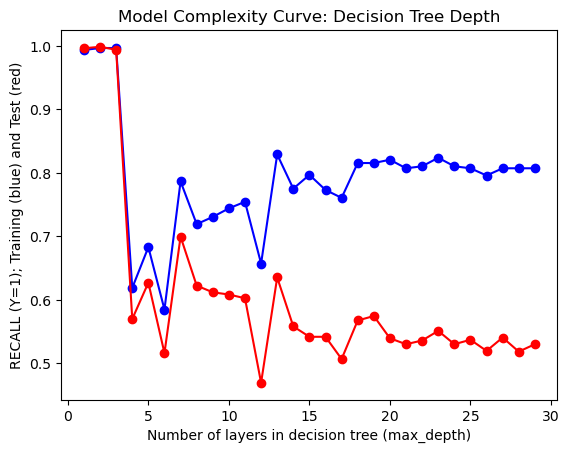

In [204]:
depth_train = train_results[:, 0]
train_recall = train_results[:, 3]
depth_test = test_results[:, 0]
test_recall = test_results[:, 3]

plt.plot(depth_train, train_recall, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_recall, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('RECALL (Y=1); Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

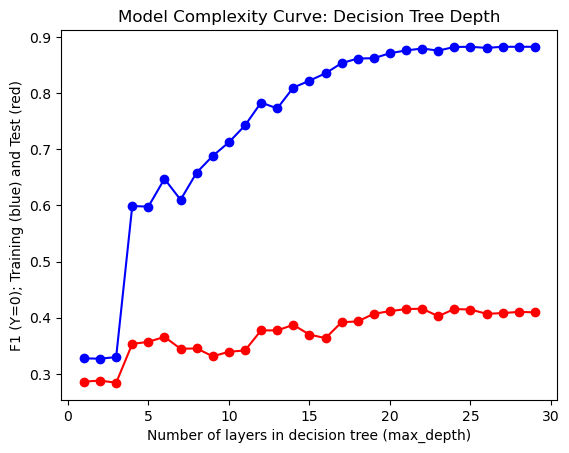

In [205]:
depth_train = train_results[:, 0]
train_recall = train_results[:, 4]
depth_test = test_results[:, 0]
test_recall = test_results[:, 4]

plt.plot(depth_train, train_recall, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_recall, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('F1 (Y=0); Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

Since the oversample method did not worked, we need to try to downsample the data to make the data more balanced. From the result we can see that even with the down sample, the bias for the majority class is still very strong when the tree is not deep. After the depth growing, the recall for both class are getting more close to each other. However, the F1 score for the minority class is still not good enough. It seems the precision has been trade off too much for the recall and we are unable to find a sweet spot to make the model predict both class well.

### Use a random forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [207]:
random_forest_model = RandomForestClassifier(n_estimators=300, random_state=42)
random_forest_model.fit(x_train_down, y_train_down)

RandomForestClassifier(n_estimators=300, random_state=42)

In [208]:
y_pred = random_forest_model.predict(x_test)

In [209]:
f1_score(y_test, y_pred, pos_label=0)

0.39449541284403666

In [210]:
precision_score(y_test, y_pred, pos_label=0)

0.31386861313868614

In [211]:
recall_score(y_test, y_pred, pos_label=0)

0.5308641975308642

Random forest also perform not good in this problem. To receive a 0.53 recall for the majority class the precision has dropped to 0.31, which means the model did not learned how to predict the minority class. We might need to try other methods or whether there is a relationship between the features and the labels or perhaps the data quality is not good enough.

## Regression Tree

In [140]:
# Prepare the data
df_compare.columns

Index(['user_id', 'track_id', 'album_id', 'timestamp', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'id', 'country',
       'age', 'gender', 'creation_time', 'age_group'],
      dtype='object')

In [141]:
target = df_compare['tempo']

In [143]:
df_compare.columns

Index(['user_id', 'track_id', 'album_id', 'timestamp', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'id', 'country',
       'age', 'gender', 'creation_time', 'age_group'],
      dtype='object')

### See the distribution of the tempo

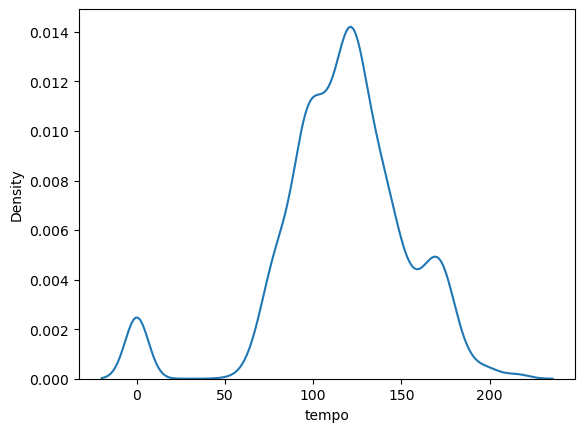

In [183]:
sns.kdeplot(df_compare['tempo'])
plt.show()

We can see the tempo of the music are baiscally distributed as a bell curve in the range from 50 to 200. There are also a group of data has a tempo of 0, which is most likely white noise or other type of audio that does not has a tempo value as we seen in the former sections.

In [147]:
X_tempo = df_compare.drop(['tempo', 'user_id', 'track_id', 'album_id', 'timestamp', 'id', 'country', 'creation_time', 'age_group'], axis=1)

In [148]:
# Split the data into training and testing sets.
train_size = 0.8
training_mask = df_compare.sample(frac=train_size, random_state=10).index

x_tempo_train = X_tempo.loc[training_mask]
y_tempo_train = target.loc[training_mask]
x_tempo_test = X_tempo.drop(training_mask)
y_tempo_test = target.drop(training_mask)

### Tune the regression tree

Here we use the combination of MAE and R square to get the optimal parameter. Where MAE is used for measure the error of the model and R suqare is to evaluate how good the tree fit the data.

In [150]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [177]:
test_tempo_results=[]
train_tempo_results=[]

for num_layer in range(1,30):
    model = tree.DecisionTreeRegressor(max_depth=num_layer)
    model = model.fit(x_tempo_train, y_tempo_train)

    yp_train=model.predict(x_tempo_train)
    yp_test=model.predict(x_tempo_test)

    # print(y_pred.shape)
    test_tempo_results.append([num_layer,mean_absolute_error(y_tempo_test, yp_test),r2_score(y_tempo_test, yp_test)])
    train_tempo_results.append([num_layer,mean_absolute_error(y_tempo_train, yp_train),r2_score(y_tempo_train, yp_train)])

In [179]:
test_results = np.array(test_tempo_results)
train_results = np.array(train_tempo_results)

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

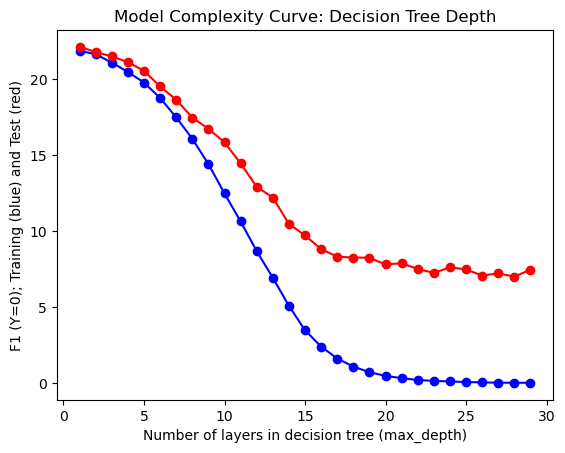

In [180]:
depth_train = train_results[:, 0]
train_recall = train_results[:, 1]
depth_test = test_results[:, 0]
test_recall = test_results[:, 1]

plt.plot(depth_train, train_recall, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_recall, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('F1 (Y=0); Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

Text(0.5, 1.0, 'Model Complexity Curve: Decision Tree Depth')

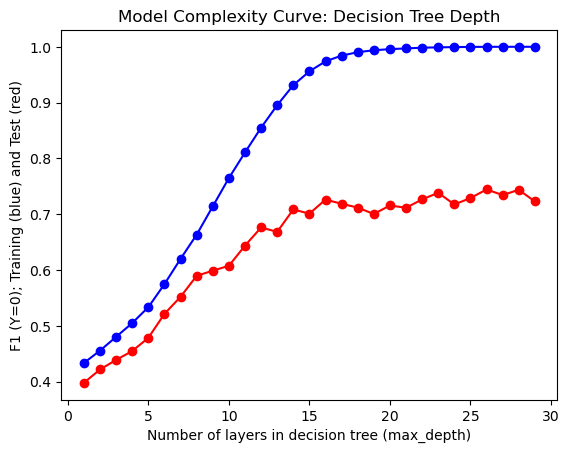

In [181]:
depth_train = train_results[:, 0]
train_recall = train_results[:, 2]
depth_test = test_results[:, 0]
test_recall = test_results[:, 2]

plt.plot(depth_train, train_recall, marker='o', color='blue', label='Training (blue)')
plt.plot(depth_test, test_recall, marker='o', color='red', label='Test (red)')

plt.xlabel('Number of layers in decision tree (max_depth)')
plt.ylabel('F1 (Y=0); Training (blue) and Test (red)')
plt.title('Model Complexity Curve: Decision Tree Depth')

From the plot of both loss function, we can see the opitmal depth is between 10 and 15, where the metric value are good and the model is not overfitting. From both MAE and R Square, we can see that the model is quite good at predicting the tempo of the music using other features, which indicate a strong realtionship between tempo and other features. This is align with the result we saw from the clustering section. 

### Build a random forest regression

In [170]:
from sklearn.ensemble import RandomForestRegressor

In [171]:
random_forest_model = RandomForestRegressor(n_estimators=300, random_state=42)
random_forest_model.fit(x_tempo_train, y_tempo_train)

RandomForestRegressor(n_estimators=300, random_state=42)

In [172]:
y_pred = random_forest_model.predict(x_tempo_test)

In [173]:
r2_score(y_tempo_test, y_pred)

0.8587170508708335

In [176]:
mean_absolute_error(y_tempo_test, y_pred)

7.403856402550109

In the random forest method, we can see that it performes even better than the single tree with optimal parameters in both MAE and R Square. This shows the random forest is more robust than the base tree model in this context.

## Final Results

For the clasification tree, the best paramter should be set to 6 and train on the oversample dataset

In [219]:
classification_optimal = tree.DecisionTreeClassifier(max_depth=6)
classification_optimal.fit(x_train_smote, y_train_smote)

DecisionTreeClassifier(max_depth=6)

In [229]:
from sklearn.tree import plot_tree

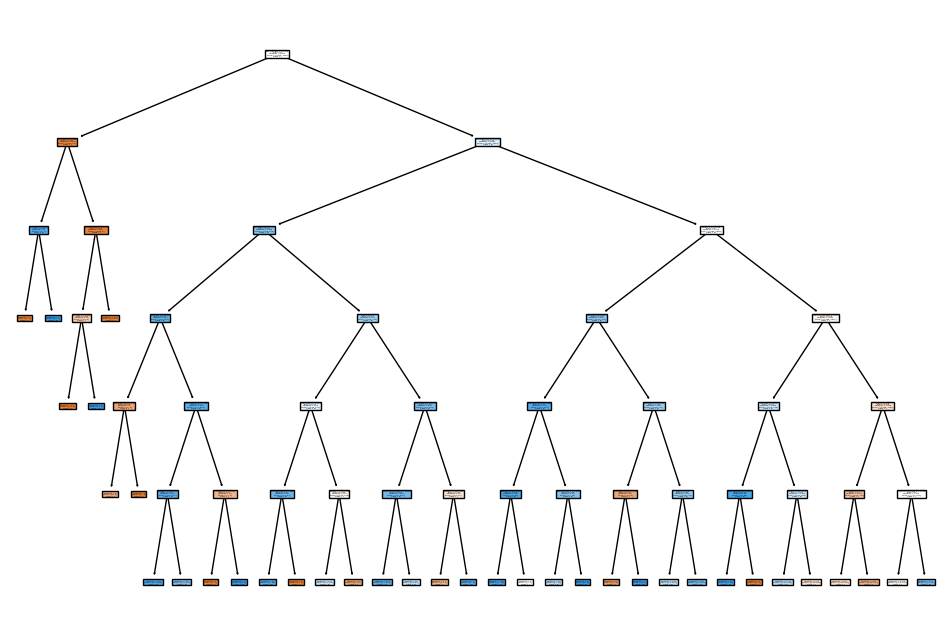

In [228]:
plt.figure(figsize=(12,8))
plot_tree(classification_optimal, feature_names=x_train.columns.values.tolist(), class_names=['f', 'm'], filled=True)
plt.show()

For the regression one, the best depth should be set to 12

In [221]:
optimal_regressor = tree.DecisionTreeRegressor(max_depth=12)
optimal_regressor.fit(x_tempo_train, y_tempo_train)

DecisionTreeRegressor(max_depth=12)

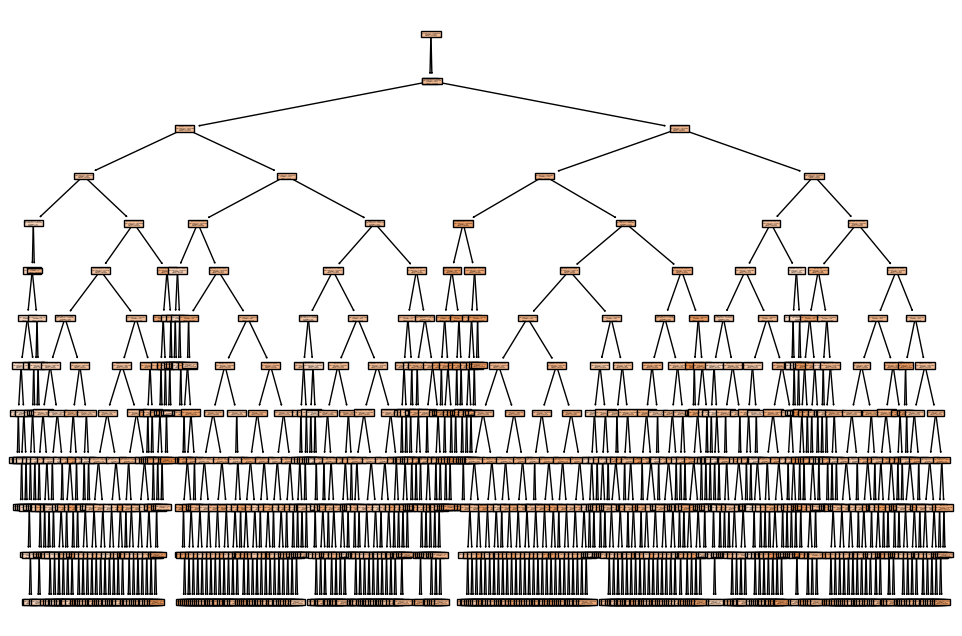

In [230]:
plt.figure(figsize=(12,8))
plot_tree(optimal_regressor, feature_names=x_tempo_test.columns.values.tolist(), filled=True)
plt.show()

## Conclusion

For conlcusion, on the classification model side, we find it very difficult to accurately predict the gender of the listener using the acoustic feature of the music they listened, especially for the female class. It could be due to the data quality, or the relationship between the feature and the gender are too weak to caputure. In the future, we might be able to collect more data and try using more complex model to see if there is a way to learn the pattern better.

On the regression side, I would say the model is sufficient to predict the tempo of the music using the other features. It further confirmed what we find from the clustering section that tempo is an important feature to calssify the music. In fact, we assume if we use tempo as the feature instead of genre could potentially give us a better insight on the current day's music industry since the genre has already very vauge and mixed. This could be worth a try in the future. 